In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append('../../../')

from utils.optimization import save_model_params_to_json
from utils.plot import figsize, fig_save_and_show, config_matplotlib

config_matplotlib()
latex_img_path = "/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/"
latex_tex_path = "/home/joaoantoniocardoso/workspace_TCC/repo/thesis/tex/generated/"

def fit(soc_grid, ocv, poly_deg, lut_size):
    z = soc_grid
    inner_deg = poly_deg - 2
    
    V0 = ocv[0]       # OCV at SOC = 0
    V1 = ocv[-1]      # OCV at SOC = 1
    base = V0 + (V1 - V0) * z  # already satisfies endpoints
    residual = ocv - base      # what z(1-z)p(z) must approximate
    
    # Design matrix for p(z)
    Z = np.vander(z, N=inner_deg + 1, increasing=True)  # columns: z^0..z^inner_deg
    Phi = (z * (1 - z))[:, None] * Z                    # multiply each column by z(1-z)
    
    # Least-squares fit for c0..c_inner_deg
    c, *_ = np.linalg.lstsq(Phi, residual, rcond=None)
    
    # Build full polynomial with numpy.poly1d
    poly_z = np.poly1d([1.0, 0.0])          # represents 'z'
    base_poly = np.poly1d([V1 - V0, V0])    # (V1-V0) z + V0
    inner_poly = np.poly1d(c[::-1])         # c0 + c1 z + ... (convert to high->low)
    
    full_poly = base_poly + (poly_z * (1 - poly_z)) * inner_poly
    
    # Coefficients for your eval_poly (a0 + a1 z + ... + an z^n)
    batt_k_V_OC_coeffs = full_poly.c[::-1]
    
    # ---------------------------------------------------------------------
    # Build K-point LUT from the fitted anchored polynomial
    # ---------------------------------------------------------------------
    soc_lut = np.linspace(0.0, 1.0, lut_size)
    ocv_lut = np.polyval(full_poly, soc_lut)

    return batt_k_V_OC_coeffs, ocv_lut

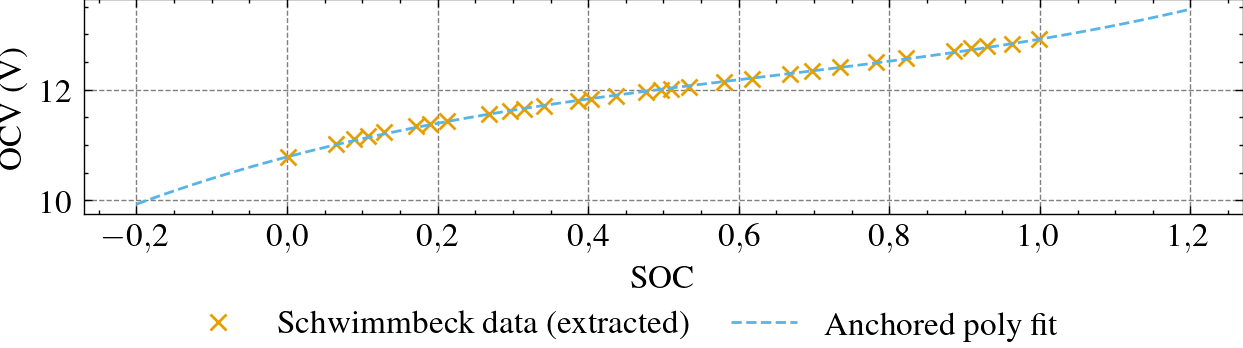

batt_k_V_OC_coeffs = np.array([10.7864583333, 3.5863893517, -3.0753011401, 1.6163721814])
batt_ocv_lut = np.array([10.7865, 10.9583, 11.1160, 11.2607, 11.3937, 11.5161, 11.6292, 11.7343, 11.8324, 11.9249, 12.0129, 12.0976, 12.1803, 12.2622, 12.3444, 12.4283, 12.5150, 12.6056, 12.7016, 12.8039, 12.9139])


In [5]:
df1 = pd.read_csv("data/agm_ocv.csv").sort_values("soc") # DOI: 10.1109/VPPC46532.2019.8952242
df2 = pd.read_csv("data/agm_ocv2.csv").sort_values("soc") # 

poly_deg = 3
lut_size = 21

soc_grid = np.linspace(0.0, 1.0, 101)
ocv1 = np.interp(soc_grid, df1["soc"].to_numpy(), df1["ocv"].to_numpy())
ocv2 = np.interp(soc_grid, df2["soc"].to_numpy(), df2["ocv"].to_numpy())
merged_mean = 0.5 * (ocv1 + ocv2)

batt_k_V_OC_coeffs,  batt_ocv_lut = fit(soc_grid, ocv1, poly_deg, lut_size)

# extrapolating
soc_grid = np.linspace(-0.2, 1.2, 101)

fig = plt.figure(figsize=(figsize(subplots=(0.4,1))))
plt.plot(df1["soc"], df1["ocv"], "x", label="Schwimmbeck data (extracted)")
# plt.plot(df2["soc"], df2["ocv"], "+", label="Dost (raw)")
# plt.plot(soc_grid, merged_mean, "-", label="Merged mean")
plt.plot(soc_grid, np.polyval(batt_k_V_OC_coeffs[::-1], soc_grid), "--", label="Anchored poly fit")
plt.xlabel("SOC")
plt.ylabel("OCV (V)")
fig_save_and_show(
    filename=f"{latex_img_path}/ocv_polynomial_fit.pdf",
    save_title="Regressão linear ",
    show_title="",
    ncol=2,
    fig=fig,
)

print("batt_k_V_OC_coeffs = np.array([",
      ", ".join(f"{a:.10f}" for a in batt_k_V_OC_coeffs),
      "])", sep="")

print("batt_ocv_lut = np.array([",
      ", ".join(f"{v:.4f}" for v in batt_ocv_lut),
      "])", sep="")


In [3]:
battery_ocv_params = dict(
    batt_k_V_OC_coeffs=batt_k_V_OC_coeffs,
    batt_ocv_lut=batt_ocv_lut,
)
save_model_params_to_json('battery_ocv_params.json', battery_ocv_params)